# In this code we will choose the final features to work with 

In [16]:
import numpy as np
import pandas as pd
from pathlib import Path

# ───────── I/O paths ─────────
CSV_IN  = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version.csv")
CSV_OUT = CSV_IN.with_name("gemini_btc_with_features.csv")

# ───────── constants ─────────
EPS          = 1e-9
BAR_PER_DAY  = 24          # 1-hour bars in one “day”
VOL_SPIKE_K  = 1.5         # volume spike threshold (× 20-bar mean)

# ═══════════════════════════════════════════════════════════════════════════
def engineer_crypto_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # ── core indicators ──────────────────────────────────────────────────

    df["EMA_7"]  = df["close"].ewm(span=7 ,  adjust=False, min_periods=7 ).mean()
    df["EMA_21"] = df["close"].ewm(span=21, adjust=False, min_periods=21).mean()
    df["SMA_20"] = df["close"].rolling(20, min_periods=20).mean()
    df["SMA_50"] = df["close"].rolling(50, min_periods=50).mean()

    Δ = df["close"].diff()
    gain = Δ.clip(lower=0); loss = -Δ.clip(upper=0)
    up   = gain.ewm(alpha=1/14, adjust=False, min_periods=14).mean()
    down = loss.ewm(alpha=1/14, adjust=False, min_periods=14).mean()
    rs = up / down.replace(0, np.nan)
    df["RSI"] = 100 - 100 / (1 + rs)

    ema12 = df["close"].ewm(span=12, adjust=False, min_periods=12).mean()
    ema26 = df["close"].ewm(span=26, adjust=False, min_periods=26).mean()
    df["MACD_line"]      = ema12 - ema26
    df["MACD_signal"]    = df["MACD_line"].ewm(span=9, adjust=False, min_periods=9).mean()
    df["MACD_histogram"] = df["MACD_line"] - df["MACD_signal"]

    df["OBV"] = (np.sign(df["close"].diff()) * df["volume"]).cumsum()

    mu = df["SMA_20"]
    σ  = df["close"].rolling(20, min_periods=20).std(ddof=0)
    df["bollinger_upper"]  = mu + 2*σ
    df["bollinger_lower"]  = mu - 2*σ
    df["bollinger_width"]  = (df["bollinger_upper"] - df["bollinger_lower"]).replace(0, EPS)

    low14  = df["low"].rolling(14, min_periods=14).min()
    high14 = df["high"].rolling(14, min_periods=14).max()
    denom  = (high14 - low14).replace(0, EPS)
    df["stoch_%K"] = 100*(df["close"]-low14)/denom
    df["stoch_%D"] = df["stoch_%K"].rolling(3, min_periods=3).mean()

    tp = (df["high"]+df["low"]+df["close"])/3
    sma_tp = tp.rolling(20, min_periods=20).mean()
    dev = tp.rolling(20, min_periods=20).apply(lambda x: np.mean(np.abs(x-x.mean())), raw=True).replace(0, EPS)
    df["CCI"] = (tp - sma_tp)/(0.015*dev)

    # helpers
    df["volume_mean_20"]   = df["volume"].rolling(20, min_periods=20).mean()
    df["resistance_level"] = df["high"].rolling(50, min_periods=50).max()
    df["support_level"]    = df["low"].rolling(50, min_periods=50).min()

    # ═════════════════════════  ATOMIC FLAGS  ═════════════════════════════
    # RSI / momentum
    df["break_upper_band"] = (df["close"] > df["bollinger_upper"]).astype(np.int8)
    df["break_lower_band"] = (df["close"] < df["bollinger_lower"]).astype(np.int8)
    df["rsi_overbought"] = (df["RSI"] > 70).astype(np.int8)
    df["rsi_oversold"]   = (df["RSI"] < 30).astype(np.int8)
    df["rsi_bullish"]    = (df["RSI"] > 50).astype(np.int8)

    # trend position
    df["above_sma20"]      = (df["close"] > df["SMA_20"]).astype(np.int8)
    df["above_sma50"]      = (df["close"] > df["SMA_50"]).astype(np.int8)
    df["ema7_above_ema21"] = (df["EMA_7"]  > df["EMA_21"]).astype(np.int8)

    # MA crosses
    cross_up   = (df["EMA_7"].shift(1) <= df["EMA_21"].shift(1)) & (df["EMA_7"] > df["EMA_21"])
    cross_down = (df["EMA_7"].shift(1) >= df["EMA_21"].shift(1)) & (df["EMA_7"] < df["EMA_21"])
    df["ema_cross_up"]   = cross_up.astype(np.int8)
    df["ema_cross_down"] = cross_down.astype(np.int8)

    # MACD states
    macd_up   = (df["MACD_line"].shift(1) <= df["MACD_signal"].shift(1)) & (df["MACD_line"] > df["MACD_signal"])
    macd_down = (df["MACD_line"].shift(1) >= df["MACD_signal"].shift(1)) & (df["MACD_line"] < df["MACD_signal"])
    df["macd_cross_up"]   = macd_up.astype(np.int8)
    df["macd_cross_down"] = macd_down.astype(np.int8)
    df["macd_positive"]   = (df["MACD_histogram"] > 0).astype(np.int8)
    df["macd_rising"]     = (df["MACD_histogram"].diff() > 0).astype(np.int8)

    # OBV momentum (24-h)
    df["obv_rising_24h"] = (df["OBV"].diff(BAR_PER_DAY) > 0).astype(np.int8)

    # Stochastic zones
    df["stoch_overbought"] = (df["stoch_%K"] > 80).astype(np.int8)
    df["stoch_oversold"]   = (df["stoch_%K"] < 20).astype(np.int8)

    # volume spike
    df["vol_spike_1_5x"] = (df["volume"] > VOL_SPIKE_K*df["volume_mean_20"]).astype(np.int8)

    # Bollinger location
    bb_pos = (df["close"] - df["bollinger_lower"]) / (df["bollinger_width"] + EPS)
    df["bb_position"]     = bb_pos.clip(0, 1)
    df["near_upper_band"] = (bb_pos > 0.80).astype(np.int8)
    df["near_lower_band"] = (bb_pos < 0.20).astype(np.int8)

    # CCI zones
    df["cci_overbought"] = (df["CCI"] >  80).astype(np.int8)   # relaxed
    df["cci_oversold"]   = (df["CCI"] < -100).astype(np.int8)

    # ═══════════════════  TWO-CONDITION COMBOS  ═══════════════════════════
    df["oversold_reversal"] = ((df["rsi_oversold"]==1) & (df["RSI"].diff() > 0)).astype(np.int8)
    df["overbought_reversal"] = ((df["rsi_overbought"]==1) & (df["RSI"].diff()<0)).astype(np.int8)
    df["momentum_alignment"]  = ((df["rsi_bullish"]==1) & (df["macd_positive"]==1)).astype(np.int8)
    df["volume_breakout"]     = ((df["vol_spike_1_5x"]==1) & (df["near_upper_band"]==1)).astype(np.int8)
    df["volume_breakdown"]    = ((df["vol_spike_1_5x"]==1) & (df["near_lower_band"]==1)).astype(np.int8)

    # ═══════════════════  HIGH-CONVICTION SCENARIOS  ═════════════════════=
    # ── Bullish set
    df["bullish_scenario_1"] = ((df["RSI"]<40)&(df["RSI"].diff(3)>0)&
                                (df["MACD_histogram"].diff()>0)&
                                (df["obv_rising_24h"]==1)).astype(np.int8)

    stoch_cross_up = (df["stoch_%K"].shift(1)<df["stoch_%D"].shift(1))&(df["stoch_%K"]>df["stoch_%D"])
    df["bullish_scenario_4"] = (stoch_cross_up &
                                (df["RSI"].rolling(5).min()<35) &
                                (df["RSI"]>40) &
                                (df["macd_positive"]==1)).astype(np.int8)

    cci_bounce = (df["CCI"].rolling(3).min()<-100)&(df["CCI"]>-50)
    df["bullish_scenario_5"] = (
    cci_bounce &
    (df["ema7_above_ema21"] == 1) &
    (df["vol_spike_1_5x"] == 1) &
    (df["above_sma20"] == 1)  # Changed from resistance check
        ).astype(np.int8)
    #  • Bull 2 – breakout+volume
    df["bullish_scenario_2"] = ((df["near_upper_band"]==1) &
                                (df["vol_spike_1_5x"]==1) &
                                (df["ema7_above_ema21"]==1) &
                                (df["macd_positive"]==1) &
                                (df["macd_rising"]==1)).astype(np.int8)

    #  • Bull 3 – EMA cross-up mid-RSI
    df["bullish_scenario_3"] = ((df["ema_cross_up"]==1) &
                                df["RSI"].between(50,70) &
                                (df["macd_positive"]==1) &
                                (df["above_sma20"]==1)).astype(np.int8)

    #  • Bull 6 – band-widen momentum
    df["bullish_scenario_6"] = ((df["bollinger_width"].diff()>0) &
                                (bb_pos>0.80) &
                                df["RSI"].between(55,65) &
                                (df["obv_rising_24h"]==1)).astype(np.int8)

    # ── Bearish set
    df["bearish_scenario_1"] = ((df["rsi_overbought"]==1) &
                                (df["RSI"].diff()<0) &
                                (df["MACD_histogram"].diff()<0) &
                                (df["obv_rising_24h"]==0)).astype(np.int8)

    touch_fail = (df["high"]>df["bollinger_upper"])&(df["close"]<df["bollinger_upper"])
    df["bearish_scenario_2"] = (touch_fail &
                                (df["RSI"]>60) &
                                (df["MACD_histogram"].diff()<0)).astype(np.int8)

    df["bearish_scenario_3"] = ((df["ema7_above_ema21"]==0) &
                                (df["RSI"]<45) &
                                (df["vol_spike_1_5x"]==1) &
                                (df["near_lower_band"]==1)).astype(np.int8)

    df["bearish_scenario_4"] = ((df["stoch_%K"]<80) &
                                (df["stoch_%K"]<df["stoch_%D"]) &
                                (df["MACD_histogram"].diff()<0) &
                                (df["above_sma50"]==0)).astype(np.int8)

    cci_breakdown = (df["CCI"].rolling(3).max()>100)&(df["CCI"]<50)
    df["bearish_scenario_5"] = (cci_breakdown &
                                (df["ema7_above_ema21"]==0) &
                                (df["RSI"]<50)).astype(np.int8)

    df["bearish_scenario_6"] = ((df["near_lower_band"]==1) &
                                (df["MACD_line"]<0) &
                                (df["RSI"]<40) &
                                (df["obv_rising_24h"]==0)).astype(np.int8)
    
    df["target"] = (df["close"].shift(-1) > df["close"]).astype(np.int8)


    return df
# ═══════════════════════════════════════════════════════════════════════════

# ── load, transform, run ──────────────────────────────────────────────────
df_raw = (pd.read_csv(CSV_IN, parse_dates=["date"])
            .rename(columns={"date":"timestamp", "Volume BTC":"volume"})
            .set_index("timestamp"))
df_raw["volume"] = np.log1p(df_raw["volume"])   # log-volume transform

df_feat = engineer_crypto_features(df_raw).dropna()
df_feat.to_csv(CSV_OUT)
print(f"✅ Features written → {CSV_OUT}")

# ── hit-rate check for every binary flag ───────────────────────────────────
bin_cols = [c for c in df_feat.columns if df_feat[c].dtype == np.int8]
print("\nBinary feature hit-rates (ascending):")
for col, pct in (df_feat[bin_cols].mean()*100).sort_values().items():
    print(f"{col:<25} {pct:6.2f}%  1s")


✅ Features written → C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_with_features.csv

Binary feature hit-rates (ascending):
bearish_scenario_1          0.07%  1s
bullish_scenario_5          0.09%  1s
bullish_scenario_4          0.26%  1s
bearish_scenario_5          0.46%  1s
bullish_scenario_1          0.78%  1s
bearish_scenario_2          1.21%  1s
oversold_reversal           1.28%  1s
bullish_scenario_3          1.84%  1s
bullish_scenario_2          1.88%  1s
bearish_scenario_3          1.95%  1s
overbought_reversal         2.05%  1s
volume_breakdown            2.14%  1s
volume_breakout             2.46%  1s
ema_cross_down              2.50%  1s
ema_cross_up                2.50%  1s
macd_cross_down             3.80%  1s
macd_cross_up               3.80%  1s
rsi_oversold                4.85%  1s
bullish_scenario_6          5.65%  1s
break_lower_band            6.05%  1s
break_upper_band            6.66%  1s
vol_spike_1

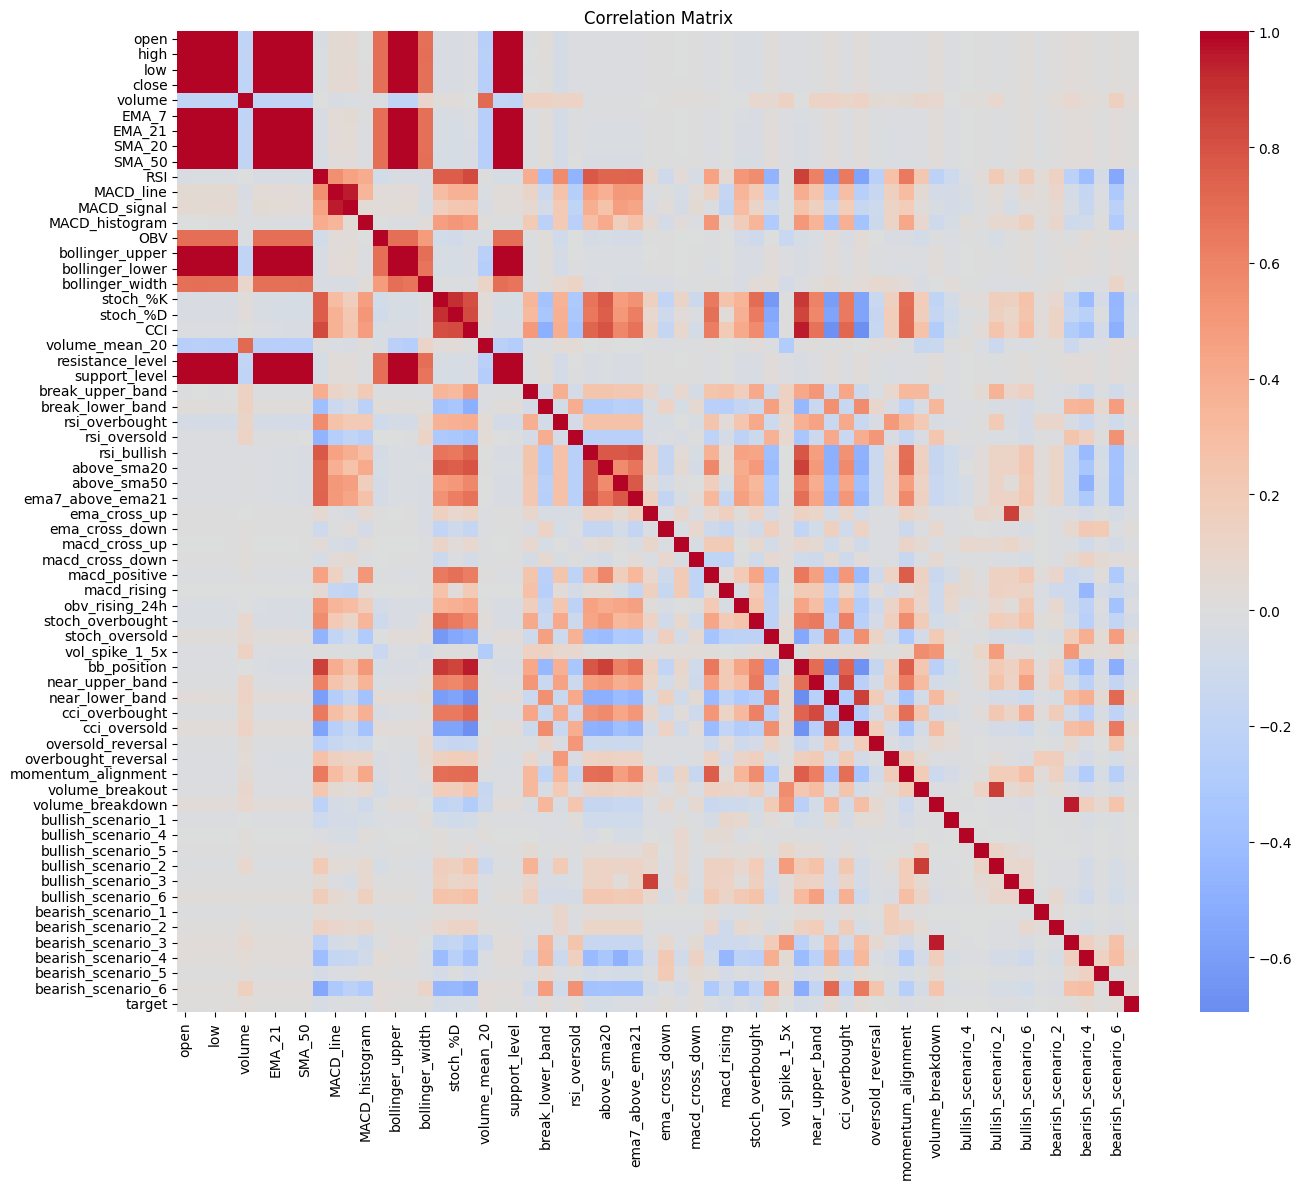


Highly correlated pairs (|corr| > 0.8):

       feature_1          feature_2  correlation
          EMA_21             SMA_20     0.999988
            high              close     0.999977
            open               high     0.999976
             low              close     0.999972
            open              EMA_7     0.999968
            open                low     0.999965
            open              close     0.999959
            high              EMA_7     0.999958
           close              EMA_7     0.999949
            high                low     0.999946
             low              EMA_7     0.999938
           EMA_7             EMA_21     0.999933
           EMA_7             SMA_20     0.999897
            open             EMA_21     0.999848
            high             EMA_21     0.999839
          SMA_20    bollinger_upper     0.999820
           close             EMA_21     0.999817
          EMA_21    bollinger_upper     0.999813
          SMA_20    bolling

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# ── compute correlation matrix ──
corr_matrix = df_feat.corr(numeric_only=True)

# ── plot (optional, for visual inspection) ──
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False, fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# ── print all pairs with high correlation ──
threshold = 0.7
print("\nHighly correlated pairs (|corr| > 0.8):\n")
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={0: "correlation", "level_0": "feature_1", "level_1": "feature_2"})
)

high_corr = corr_pairs[abs(corr_pairs["correlation"]) > threshold]
high_corr_sorted = high_corr.sort_values(by="correlation", key=np.abs, ascending=False)

print(high_corr_sorted.to_string(index=False))
